In [1]:
from __future__ import print_function
from __future__ import absolute_import

import warnings
import os
import random
import numpy as np
import threading

import keras
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D, Deconvolution2D
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import merge, concatenate, add
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from imagenet_utils import _obtain_input_shape
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

Using TensorFlow backend.


In [2]:
def create_model(input_tensor=None, input_shape=None):

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=False)

    if input_tensor is None:
        inputs = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            inputs = Input(tensor=input_tensor, shape=input_shape)
        else:
            inputs = input_tensor
    
    # Encoder 1
    e11 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
    e12 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(e11)
    e13 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(e12)

    # Encoder 2
    e21 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(e13)
    e22 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(e21)
    e23 = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(e22)

    # Encoder 3
    e31 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(e23)
    e32 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(e31)
    e33 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(e32)
    e34 = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(e33)

    # Encoder 4
    e41 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(e34)
    e42 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(e41)
    e43 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(e42)
    e44 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(e43)

    # Encoder 5
    e51 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(e44)
    e52 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(e51)
    e53 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(e52)
    e54 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(e53)
    
    # Now lets decode the representation
    # Using residual connections (in this case concatenate)
    
    # Decoder 5
    d51 = Deconvolution2D(512, (3, 3), activation='relu', padding='same', name='block5_deconv1')(e54)
    d52 = Deconvolution2D(512, (3, 3), activation='relu', padding='same', name='block5_deconv2')(d51)
    d53 = Deconvolution2D(512, (3, 3), activation='relu', padding='same', name='block5_deconv3')(d52)
    d54 = UpSampling2D((2, 2), name='block5_upsample')(d53)
    
    # Decoder 4
    merged = concatenate([d54, e44])
    d41 = Deconvolution2D(256, (3, 3), activation='relu', padding='same', name='block4_deconv1')(merged)
    d42 = Deconvolution2D(256, (3, 3), activation='relu', padding='same', name='block4_deconv2')(d41)
    d43 = Deconvolution2D(256, (3, 3), activation='relu', padding='same', name='block4_deconv3')(d42)
    d44 = UpSampling2D((2, 2), name='block4_upsample')(d43)
    
    # Decoder 3
    merged = concatenate([d44, e34])
    d31 = Deconvolution2D(128, (3, 3), activation='relu', padding='same', name='block3_deconv1')(merged)
    d32 = Deconvolution2D(128, (3, 3), activation='relu', padding='same', name='block3_deconv2')(d31)
    d33 = Deconvolution2D(128, (3, 3), activation='relu', padding='same', name='block3_deconv3')(d32)
    d34 = UpSampling2D((2, 2), name='block3_upsample')(d33)
    
    # Decoder 2
    merged = concatenate([d34, e23])
    d21 = Deconvolution2D(64, (3, 3), activation='relu', padding='same', name='block2_deconv1')(merged)
    d22 = Deconvolution2D(64, (3, 3), activation='relu', padding='same', name='block2_deconv2')(d21)
    d23 = UpSampling2D((2, 2), name='block2_upsample')(d22)
    
    # Decoder 1
    merged = concatenate([d23, e13])
    d11 = Deconvolution2D(32, (3, 3), activation='relu', padding='same', name='block1_deconv1')(merged)
    d12 = Deconvolution2D(32, (3, 3), activation='relu', padding='same', name='block1_deconv2')(d11)
    d13 = UpSampling2D((2, 2), name='block1_upsample')(d12)
    
    d01 = Conv2D(16, (3, 3), activation='relu',    padding='same', name='out1')(d13)
    d02 = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='out2')(d01)


    
    # Create model.
    vgg16 = Model(inputs, e54, name='vgg16')
    weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                            WEIGHTS_PATH_NO_TOP,
                            cache_subdir='models')
    
    # Load weights of vgg16 and fix them (set non-trainable)
    vgg16.load_weights(weights_path)
    for l in vgg16.layers:
        l.trainable = False
    
    model = Model(inputs, d02, name='colorizer')
    print( model.summary() )
    return model, vgg16

In [3]:
model, vgg = create_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, None, None, 64 1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Conv2D)            (None, None, None, 64 36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, None, None, 64 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [4]:
img = load_img('./Shifen-Waterfall-Taiwan.jpg', target_size=(224, 224))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# res_first = first.predict([x], 1, verbose=1)
res_second = model.predict([x], 1, verbose=1)

# print(res_first[0].shape)
print(res_second[0].shape)

1/1 [==============================] - 1s
(224, 224, 3)


# Train

In [5]:
model.compile(loss='kullback_leibler_divergence', optimizer='adam')

In [6]:
class BatchGenerator:

    def __init__(self, image_paths, batch_size, image_height, image_width):
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.image_height = image_height
        self.image_width = image_width
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            batch_features = np.zeros((self.batch_size, self.image_height, self.image_width, 3))
            batch_labels   = np.zeros((self.batch_size, self.image_height, self.image_width, 3))

            for i in range(self.batch_size):
                path= random.choice(self.image_paths)
                image = load_img(path, target_size=(self.image_height, self.image_width))
                image_gray = image.convert('L')

                batch_features[i,:,:,0] = image_gray
                batch_features[i,:,:,1] = image_gray
                batch_features[i,:,:,2] = image_gray
                batch_labels[i] = load_img(path, target_size=(self.image_height, self.image_width))
            return batch_features, batch_labels

In [7]:
train_root = './test2014/'
image_paths = [train_root + item for item in os.listdir(train_root) if item.endswith('.jpg') ]
print(image_paths[0])
im = load_img(image_paths[0], grayscale=False, target_size=(224, 224))
im_grey = im.convert('L')
im_grey = np.array( im_grey )
im_grey.reshape((224, 224, 1))
print(np.array(im).shape)
print(im_grey.shape)

./test2014/COCO_test2014_000000174879.jpg
(224, 224, 3)
(224, 224)


In [8]:
batch_size = 7
steps_per_epoch = 20 # len(image_paths) / batch_size
print( steps_per_epoch, 'iterations per one epoch' )
print( 'There are', len(image_paths), 'images in total' )

20 iterations per one epoch
There are 40775 images in total


In [13]:
model.fit_generator(BatchGenerator(image_paths=image_paths, 
                              batch_size=batch_size, 
                              image_height=224,
                              image_width=224), 
                    steps_per_epoch = steps_per_epoch, 
                    epochs = 5,
                    callbacks=[TensorBoard(log_dir='/tmp/coloring')], 
                    verbose=1, 
                    workers=1)

Epoch 1/5
20/20 [==============================] - 266s - loss: 0.7550    
Epoch 2/5
20/20 [==============================] - 268s - loss: -7.8445e-08    
Epoch 3/5
20/20 [==============================] - 270s - loss: -7.6939e-08    
Epoch 4/5
20/20 [==============================] - 274s - loss: -6.1313e-08    
Epoch 5/5
20/20 [==============================] - 273s - loss: -7.2055e-08    


# Evaluate

In [21]:
path= random.choice(image_paths)
image = load_img(path, target_size=(224, 224))
image_gray = image.convert('L')

inp = np.zeros((image.height, image.width, 3))
inp[:,:,0] = image_gray
inp[:,:,1] = image_gray
inp[:,:,2] = image_gray

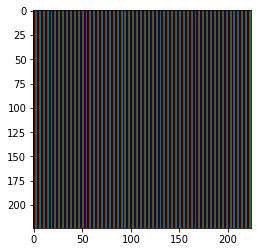

In [24]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

out = model.predict(np.array([inp]), batch_size=1)
img = Image.fromarray(out[0], 'RGB')
plt.imshow(img)

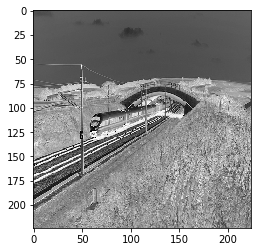

In [25]:
plt.imshow(inp)